In [1]:
# Import necessary modules

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
import geopandas as gpd
from urllib.request import urlretrieve
import requests
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
from datetime import datetime, timedelta
import json
import sys
import math
from geopy.distance import distance
from matplotlib.colors import to_rgba
from collections import defaultdict

In [2]:
# Establish directory locations

parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir    = os.path.join(parent_dir, 'Output/sat_plot')
NEODASS_dir   = os.path.join(satellite_dir, 'NEODASS')
floats_dir    = os.path.join(parent_dir, 'Data/Floats')

In [10]:
# Plotting preferences

# Global
min_lon = -35 #-35
max_lon = -5 #-5
min_lat = 55 #55
max_lat = 66 #66

min_lon_default = min_lon 
max_lon_default = max_lon
min_lat_default = min_lat
max_lat_default = max_lat

additional_suffix = '_TEST'

# Float colors
# For additional floats, add the name (as it appears in the 'Float_positions.csv') and color you'd like (as a hexcode)
float_colors = {
        '4903532':  '#B4184C',
        'navis102': '#F5A300',
        '1902637':  '#0000E0',
        'navis101': '#FBFF1F'}

# CHLA
skip_chla            = False
CHLA_color           = 'YlGnBu_r'
CHLA_plot_as_log     = True # Default True
CHLA_plot_lim_max    = 10   # Default 10
CHLA_plot_lim_min    = 0.1  # Default 0.1

# SST
skip_sst             = True
SST_color            = 'YlOrRd'
SST_plot_as_log      = False # Default False
SST_plot_lim_max     = 15    # Default 15
SST_plot_lim_min     = 5     # Default 5

# SSH
skip_sla             = True
SSH_color            = 'RdBu'
SSH_plot_as_log      = False # Default False
SSH_plot_lim_max     = 0.5   # Default  0.5
SSH_plot_lim_min     = -0.5  # Default -0.5

# Surface Currents
skip_ssc             = False
SSC_color            = 'YlGnBu_r'
SSC_plot_as_log      = False # Default False
SSC_plot_lim_max     = 5   # Default 5
SSC_plot_lim_min     = 0   # Default 0

# BBP
skip_bbp             = True
BBP_color            = 'YlGnBu_r'
BBP_plot_as_log      = True
BBP_plot_lim_max     = 0.1
BBP_plot_lim_min     = 0.0001

# PIC
skip_pic             = True
PIC_color            = 'YlGnBu_r'
PIC_plot_as_log      = True
PIC_plot_lim_max     = 0.1
PIC_plot_lim_min     = 0.0000001

In [11]:
# Function to generate points on a circle centered at (lat, lon) with a given radius
def generate_circle_points(lat, lon, radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_points = []
    for angle in angles:
        point = distance(kilometers=radius_km).destination((lat, lon), angle)
        circle_points.append((point.latitude, point.longitude))
    
    return np.array(circle_points)

In [12]:
### Plotting most recent data from CMEMS
## List most recent files

# List to store matching file names
matching_files = []

# Loop through the files in the directory
for filename in os.listdir(satellite_dir):
    if filename.endswith('.nc'):
        matching_files.append(filename)

print(matching_files)

## List variables from these files
# Dictionary to store files by their base names (excluding '_a_' or '_b_') and key variables
file_dict = {}

for file in matching_files:
    # Identify the base name by removing '_a' or '_b' if present
    base_name = file.replace('_a', '_').replace('_b', '_')
    if base_name not in file_dict:
        file_dict[base_name] = {}
    filepath = os.path.join(satellite_dir, file)
    ds = xr.open_dataset(filepath)
    variables = list(ds.data_vars.keys())

    print(file)
    print(variables)

    key_variables = [var for var in variables if 'longitude' not in var.lower() and 'latitude' not in var.lower()]

    if key_variables:
        for key_variable in key_variables:
            if file not in file_dict[base_name]:
                file_dict[base_name][file] = {}
            file_dict[base_name][file][key_variable] = {
                'variable': key_variable,
            }
    else:
        print(f"No suitable key variable found in file: {file}")

    ds.close()

# Print the results
for base_name, files in file_dict.items():
    for file, key_variable in files.items():
        print(f'File: {file}')
        print(f'Base Name: {base_name}')
        print(f'Key Variable: {key_variable}')

    filepath  = os.path.join(satellite_dir, file)
    dataset = xr.open_dataset(filepath)

    # Print global attributes
    print("Global attributes:")
    for attr_name, attr_value in dataset.attrs.items():
        print(f"  {attr_name}: {attr_value}")

    # Print variable attributes
    print("\nVariable attributes:")
    for var_name, var in dataset.variables.items():
        print(f"Variable: {var_name}")
        for attr_name, attr_value in var.attrs.items():
            print(f"  {attr_name}: {attr_value}")

# Initialize var_dict with categories as keys and empty dictionaries as values
var_dict = {'chl': {}, 'temp': {}, 'sla': {}, 'adt': {}, 'bbp': {}, 'dissic': {}, 'ugos':{}} 

for base_name, files in file_dict.items():
    for file, variables in files.items():
        contains_adt = False
        contains_ugos = False
        
        for key_variable, details in variables.items():
            data_var = details['variable']
            var_name_lower = data_var.lower()
            
            if 'chl' in var_name_lower and var_name_lower == 'chl':
                var_dict['chl'][file] = data_var
            elif 'temp' in var_name_lower:
                var_dict['temp'][file] = data_var
            elif 'sla' in var_name_lower:
                var_dict['sla'][file] = data_var
            elif 'adt' in var_name_lower:
                var_dict['adt'][file] = data_var
                contains_adt = True
            elif 'bbp' in var_name_lower and var_name_lower == 'bbp':
                var_dict['bbp'][file] = data_var
            elif 'dissic' in var_name_lower and var_name_lower == 'dissic':
                var_dict['dissic'][file] = data_var
            elif 'ugos' in var_name_lower and var_name_lower == 'ugos':
                contains_ugos = True
                # Delay adding 'ugos' to var_dict until after the adt check

        # After checking all variables in the file
        if contains_ugos:
            if contains_adt:
                # Add to 'adt' category if the file contains both 'adt' and 'ugos'
                var_dict['adt'][file] = data_var
            else:
                # Add to 'ugos' category if the file contains only 'ugos'
                var_dict['ugos'][file] = data_var

# We load shape files for bathymetry lines
#first_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_J_1000.shp'
#second_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_I_2000.shp'

first_line_path  = 'C:\\Users\\hanshil\\Documents\\GitHub\\biocarbon_nrt_data_viz\\data\\bathymetry\\ne_10m_bathymetry_J_1000.shp'
second_line_path = 'C:\\Users\\hanshil\\Documents\\GitHub\\biocarbon_nrt_data_viz\\data\\bathymetry\\ne_10m_bathymetry_I_2000.shp'

gdf_1000 = gpd.read_file(first_line_path)
gdf_2000 = gpd.read_file(second_line_path)

['CMEMS_cmems_mod_glo_bgc-car_anfc_0.25deg_P1D-m_April-May2024.nc', 'CMEMS_cmems_obs-oc_atl_bgc-optics_nrt_l3-multi-1km_P1D_April-May2024.nc', 'CMEMS_cmems_obs-oc_atl_bgc-plankton_nrt_l3-multi-1km_P1D_April-May2024.nc', 'CMEMS_cmems_obs-sl_eur_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D_April-May2024.nc', 'CMEMS_cmems_obs_mob_glo_phy-cur_nrt_0.25deg_P1D-m_April-May2024.nc']
CMEMS_cmems_mod_glo_bgc-car_anfc_0.25deg_P1D-m_April-May2024.nc
['dissic', 'ph', 'talk']
CMEMS_cmems_obs-oc_atl_bgc-optics_nrt_l3-multi-1km_P1D_April-May2024.nc
['BBP', 'BBP_uncertainty', 'CDM', 'CDM_uncertainty', 'flags']
CMEMS_cmems_obs-oc_atl_bgc-plankton_nrt_l3-multi-1km_P1D_April-May2024.nc
['CHL', 'CHL_uncertainty', 'DIATO', 'DIATO_uncertainty', 'DINO', 'DINO_uncertainty', 'GREEN', 'GREEN_uncertainty', 'HAPTO', 'HAPTO_uncertainty', 'MICRO', 'MICRO_uncertainty', 'NANO', 'NANO_uncertainty', 'PICO', 'PICO_uncertainty', 'PROCHLO', 'PROCHLO_uncertainty', 'PROKAR', 'PROKAR_uncertainty', 'flags']
CMEMS_cmems_obs-sl_eur_

In [15]:
# Further presets

zoom_plot    = True
skip_floats  = False
skip_gliders = False

# Load autonomy positions
csv_file = 'C:\\Users\\hanshil\\Documents\\GitHub\\biocarbon_nrt_data_viz\\Plotting_tools\\shared_data\\rt_positions.csv'  # Update this path
df = pd.read_csv(csv_file)
df['date'] = pd.to_datetime(df['date']) # Convert the 'time' column to datetime

# 130km circle around deploy point
circle_points = generate_circle_points(60, -24, 444)
circle_lats, circle_lons = circle_points[:, 0], circle_points[:, 1]

# Load float positions
float_position_path = os.path.join(floats_dir, 'Float_positions.csv')
full_position = pd.read_csv(float_position_path)

# Define unique symbols for different object types
object_symbols = {
    'glider': 'o',
    'Float': 's',
    'Ship'  : '^'
    # Add more object types and their symbols here
}

# Define colors for different objects
object_colors = {
    'unit_345': '#53599A',  # Example color
    'unit_397': '#7A7FB8',
    'unit_398': '#AFB3D4',
    'unit_405': '#32365D',
    'lovuse026d': '#F7A072',  # Example color
    'lovuse031c': '#F47E3E',  # Example color
    'lovuse032c': '#D4520C',  # Example color
    'Discovery' : '#70163C'
    # Add more object names and their colors here
}

In [25]:
additional_suffix = '_clean'
plot_markers = True
skip_floats  = False
skip_gliders = False

min_lon = min_lon_default
max_lon = max_lon_default
min_lat = min_lat_default
max_lat = max_lat_default

for var_category, files in var_dict.items():

    if skip_chla and var_category == 'chl':
        continue
    if skip_sst and var_category == 'temp':
        continue
    if skip_sla and var_category == 'sla':
        continue
    if skip_pic and var_category == 'dissic':
        continue
    if skip_bbp and var_category == 'bbp':
        continue
    if skip_ssc and var_category == 'adt':
        continue

    for day_offset in [-3,-2,-1]:  # Plot the last two days # Change this silly bit of code to be something more readable
        if len(files) > 1:
            data_vars = []
            for file, data_var in files.items():
                cur_data_var = xr.open_dataset(os.path.join(satellite_dir, file))
                data_vars.append(cur_data_var[data_var].isel(time=day_offset))
            aligned_data_vars = xr.align(*data_vars, join='outer')
            combined_data_var = aligned_data_vars[0]
            for var in aligned_data_vars[1:]:
                combined_data_var = combined_data_var.combine_first(var)
            combined_data_var_mean = np.nanmean(combined_data_var, axis=0)
            date_of_plot = str(combined_data_var['time'].data[0])[0:10]
        elif len(files) == 1:
            file, data_var = next(iter(files.items()))
            cur_data_var = xr.open_dataset(os.path.join(satellite_dir, file))
            date_of_plot = str(cur_data_var['time'].data[day_offset])[0:10]
            combined_data_var_mean = cur_data_var[data_var].isel(time=day_offset).data
        else:
            continue

        # Dependant settings based on each variable type
        if var_category == 'chl':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Chlorophyll (' + xx_plot_units + ')'
            xx_plot_min = CHLA_plot_lim_min
            xx_plot_max = CHLA_plot_lim_max
            color = CHLA_color
            log_scaling = CHLA_plot_as_log
            xx_output_dir_name = 'Chla'

        elif var_category == 'temp':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            if xx_plot_units == 'kelvin':
                degree_sign = u'\N{DEGREE SIGN}'
                xx_plot_cbar_label = 'Sea Surface Temperature (' + degree_sign + 'C)'
                if len(files) > 1:
                    combined_data_var_mean -= 273.15
                else:
                    cur_data_var[data_var] = cur_data_var[data_var] - 273.15
                xx_plot_min = SST_plot_lim_min
                xx_plot_max = SST_plot_lim_max
                color = SST_color
                log_scaling = SST_plot_as_log
                xx_output_dir_name = 'SST'
                
        elif var_category == 'sla':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Sea level anomaly (' + xx_plot_units + ')'
            xx_plot_min = SSH_plot_lim_min
            xx_plot_max = SSH_plot_lim_max
            color = SSH_color
            log_scaling = SSH_plot_as_log
            xx_output_dir_name = 'SLA'

        elif var_category == 'adt':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Sea surface velocity (' + xx_plot_units + 's$^{-1}$)'
            xx_plot_min = SSH_plot_lim_min
            xx_plot_max = SSH_plot_lim_max
            color = SSH_color
            log_scaling = SSH_plot_as_log
            xx_output_dir_name = 'SSC_0_125_prod'

        elif var_category == 'ugos':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Sea surface velocity (' + xx_plot_units + 's$^{-1}$)'
            xx_plot_min = SSH_plot_lim_min
            xx_plot_max = SSH_plot_lim_max
            color = SSH_color
            log_scaling = SSH_plot_as_log
            xx_output_dir_name = 'SSC_0_25_prod'

        elif var_category == 'bbp':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Particulate backscatter (' + xx_plot_units + ')'
            xx_plot_min = BBP_plot_lim_min
            xx_plot_max = BBP_plot_lim_max
            color = BBP_color
            log_scaling = BBP_plot_as_log
            xx_output_dir_name = 'BBP'

        elif var_category == 'dissic':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'PIC (' + xx_plot_units + ')'
            xx_plot_min = PIC_plot_lim_min
            xx_plot_max = PIC_plot_lim_max
            color = PIC_color
            log_scaling = PIC_plot_as_log
            xx_output_dir_name = 'PIC'

        print(var_category)
        norm = colors.LogNorm(vmin=xx_plot_min, vmax=xx_plot_max) if log_scaling else colors.Normalize(vmin=xx_plot_min, vmax=xx_plot_max)
        NEODASS_data_to_plot_1day = np.clip(combined_data_var_mean, xx_plot_min, xx_plot_max)

        # If the first dimension of the data is 1, remove it
        if NEODASS_data_to_plot_1day.shape[0] == 1:
            NEODASS_data_to_plot_1day = NEODASS_data_to_plot_1day[0]

        date_of_plot_filter = datetime.strptime(date_of_plot, '%Y-%m-%d')
        date_of_plot_filter_plus_one = date_of_plot_filter + pd.Timedelta(days=1)
        df_filtered = df[df['date'] <= date_of_plot_filter_plus_one]

        if plot_markers == False:
            additional_suffix = '_clean_zoom'

            min_lat = 55.5
            max_lat = 64.5
            min_lon = -30
            max_lon = -15

        if var_category == 'ugos':

            fig = plt.figure(figsize=(15, 15))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
            ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

            # Extract the lon and lat from the dataset only once
            x = cur_data_var['longitude'].data
            y = cur_data_var['latitude'].data

            #From the U and V vector compute the speed, we use it as our colour map
            u = cur_data_var['ugos'].isel(time=day_offset).data
            v = cur_data_var['vgos'].isel(time=day_offset).data
            speed = np.sqrt(u**2 + v**2)

            #Plot the current vectors field and the coastline
            im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree(), width = 0.002)

            cbar = plt.colorbar(im, ax=ax, label=xx_plot_cbar_label)

            print('Made a quiver')

        elif var_category == 'adt':
            
            if min_lon > -30:
                adt_min_lon = min_lon
            else:
                adt_min_lon = -30

            fig = plt.figure(figsize=(15, 15))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
            ax.set_extent([adt_min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

            # Extract the lon and lat from the dataset only once
            x = cur_data_var['longitude'].data
            y = cur_data_var['latitude'].data

            #From the U and V vector compute the speed, we use it as our colour map
            u = cur_data_var['ugos'].isel(time=day_offset).data
            v = cur_data_var['vgos'].isel(time=day_offset).data
            speed = np.sqrt(u**2 + v**2)

            #Plot the current vectors field and the coastline
            im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree(), width = 0.002)

            cbar = plt.colorbar(im, ax=ax, label=xx_plot_cbar_label)

        else:

            fig = plt.figure(figsize=(20, 10))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
            ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
            
            im = ax.pcolormesh(cur_data_var['longitude'].data, 
                               cur_data_var['latitude'].data, 
                               NEODASS_data_to_plot_1day, 
                               cmap=color, 
                               norm=norm,
                               transform=ccrs.PlateCarree())
        
            cbar = plt.colorbar(im, ax=ax, label=xx_plot_cbar_label)

            print('Made a heatmap')

        legend_handles = []

        if plot_markers:

            # Plotting autonomy/markers
    
            date_of_plot_filter = datetime.strptime(date_of_plot, '%Y-%m-%d')
            date_of_plot_filter_plus_one = date_of_plot_filter + pd.Timedelta(days=1)
            df_filtered = df[df['date'] <= date_of_plot_filter_plus_one]
    
            legend_handles = []
    
            # Process each unique object type
            for obj_type, symbol in object_symbols.items():
    
                if obj_type == 'Float' and skip_floats:
                    continue
                if obj_type == 'glider' and skip_gliders:
                    continue
    
                # Filter data for the current object type
                type_data = df_filtered[df_filtered['platform_type'] == obj_type]
                unique_names = type_data['platform_id'].unique()
                
                for name in unique_names:
                    obj_data = type_data[type_data['platform_id'] == name].sort_values(by='date', ascending=False)  # Sort in descending order
                    
                    # Get the colors and opacities for the points
                    rgba_color = to_rgba(object_colors.get(name, '#000000'))  # Default to black if not found
                    num_positions = len(obj_data)
                    alphas = np.linspace(1, 0.1, min(num_positions, 10))  # Reverse the opacity gradient
            
                    # Plot the positions and lines, with the first 10 points having a decreasing alpha
                    for i, (index, row) in enumerate(obj_data.iterrows()):
                        if i >= 10:  # Only plot up to the 10 most recent points
                            break
                        alpha = alphas[i]
                        rgba_color_with_alpha = (*rgba_color[:3], alpha)
                        marker_edge_color = (*rgba_color[:3], alpha)  # Marker edge color follows opacity gradient
                        ax.scatter(row['lon'], row['lat'], color=rgba_color_with_alpha, edgecolor=marker_edge_color, 
                                transform=ccrs.PlateCarree(), zorder=3, marker=symbol, s=5)
            
                        if i > 0:
                            prev_row = obj_data.iloc[i - 1]
                            ax.plot([prev_row['lon'], row['lon']],
                                    [prev_row['lat'], row['lat']],
                                    color=rgba_color_with_alpha, transform=ccrs.PlateCarree(), zorder=2, markersize=5)
            
                    # Create a proxy artist for each object
                    proxy = plt.Line2D([0], [0], linestyle='-', marker=symbol, color=object_colors.get(name, '#000000'), label=name)
                    legend_handles.append(proxy)
    
            unique_floats = full_position['float'].unique()
            full_position['JULD']  = pd.to_datetime(full_position['JULD'])
            full_position_filtered = full_position[full_position['JULD'] <= date_of_plot_filter_plus_one]
            
            # Plot each float's positions
            for float_name in unique_floats:
                float_data = full_position_filtered[full_position_filtered['float'] == float_name].sort_values(by='JULD', ascending=False)  # Sort in descending order
    
                # Get the colors and opacities for the points
                rgba_color = to_rgba(float_colors.get(float_name, '#000000'))  # Default to black if not found
                num_positions = len(float_data)
                alphas = np.linspace(1, 0.1, min(num_positions, 9))  # Reverse the opacity gradient
    
                # Plot the positions and lines, with the first 9 points have a decreasing alpha
                for i, (index, row) in enumerate(float_data.iterrows()):
                    alpha = alphas[i] if i < 9 else 0.1
                    rgba_color_with_alpha = (*rgba_color[:3], alpha)
                    marker_edge_color     = (*rgba_color[:3], alpha)  # Marker edge color follows opacity gradient
                    ax.scatter(row['LONGITUDE'], row['LATITUDE'], color=rgba_color_with_alpha, edgecolor=marker_edge_color, transform=ccrs.PlateCarree(), zorder=3, s=5)
    
                    if i > 0:
                        prev_row = float_data.iloc[i - 1]
                        ax.plot([prev_row['LONGITUDE'], row['LONGITUDE']],
                                [prev_row['LATITUDE'], row['LATITUDE']],
                                color=rgba_color_with_alpha, transform=ccrs.PlateCarree(), zorder=2, markersize=5)
                        
                # Create a proxy artist for each float
                proxy = plt.Line2D([0], [0], linestyle='-', marker='o', color=float_colors.get(float_name, '#000000'), label=float_name)
                legend_handles.append(proxy)
            
            # Add legend to the plot
            ax.legend(handles=legend_handles, loc='upper right')
                    # Add lon/lat grid and adjust labels
            gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
            gl.top_labels = False
            gl.right_labels = False
            
            sc3 = ax.scatter(-24,60,transform=ccrs.PlateCarree(), edgecolors='black', facecolors='none', marker='s', s=5)
            ax.plot(circle_lons, circle_lats, transform=ccrs.PlateCarree(), color='black')

            # Add legend in
            deploy_point_proxy = plt.Line2D([0], [0], linestyle='none', marker='s', color='black', markersize=10, markerfacecolor='none', label='Deploy Point')
            legend_handles.append(deploy_point_proxy)
            ax.legend(handles=legend_handles, loc='upper left')
            
        gdf_1000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='k', facecolor='none')
        gdf_2000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.3, edgecolor='k', facecolor='none')

        # Add coastlines
        ax.add_feature(cfeature.COASTLINE)

        # Add lon/lat grid and adjust labels
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.right_labels = False

        # Plot title
        plot_title = f'CMEMS_{xx_output_dir_name} {date_of_plot}'
        ax.set_title(plot_title, fontsize=24)

        # Save output
        save_dir = os.path.join(output_dir, f'{xx_output_dir_name}{"_log" if log_scaling else ""}{additional_suffix}')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        filename = f'{xx_output_dir_name}{"_log" if log_scaling else ""}_{date_of_plot}_CMEMS.png'
        plt.savefig(os.path.join(save_dir, filename))
        
        plt.clf()
        plt.close()

chl
Made a heatmap
chl
Made a heatmap
chl
Made a heatmap
adt
adt
adt
ugos
Made a quiver
ugos
Made a quiver
ugos
Made a quiver


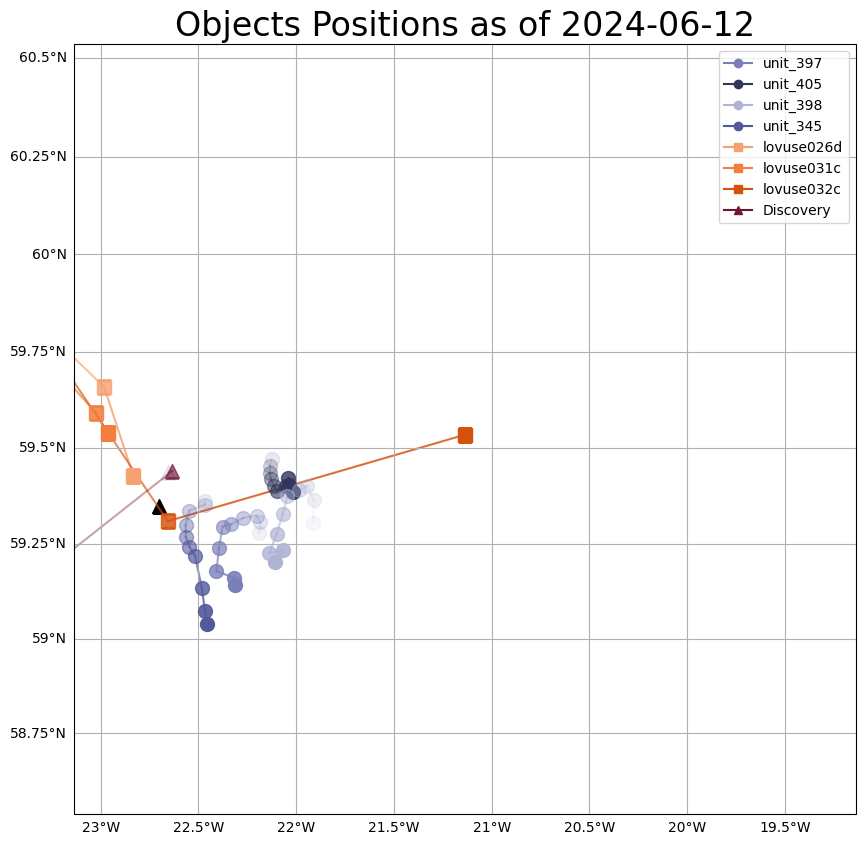

In [8]:
# Plotting additional autonomy

min_lon = -24.05 #-35
max_lon = -22.5 #-5
min_lat = 59 #55
max_lat = 60.1 #66

# Load the CSV file into a DataFrame
csv_file = 'C:\\Users\\hanshil\\Documents\\GitHub\\biocarbon_nrt_data_viz\\Plotting_tools\\shared_data\\rt_positions.csv'  # Update this path
df = pd.read_csv(csv_file)

# Convert the 'time' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Define the date_of_plot as a string in the format 'YYYY-MM-DD'
date_of_plot = '2024-06-12'  # Example date
date_of_plot_dt = datetime.strptime(date_of_plot, '%Y-%m-%d')

# Filter out rows with 'time' greater than date_of_plot
df = df[df['date'] <= date_of_plot_dt]

# Define unique symbols for different object types
object_symbols = {
    'glider': 'o',
    'Float': 's',
    'Ship'  : '^'
    # Add more object types and their symbols here
}

# Define colors for different objects
object_colors = {
    'unit_345': '#53599A',  # Example color
    'unit_397': '#7A7FB8',
    'unit_398': '#AFB3D4',
    'unit_405': '#32365D',
    'lovuse026d': '#F7A072',  # Example color
    'lovuse031c': '#F47E3E',  # Example color
    'lovuse032c': '#D4520C',  # Example color
    'Discovery' : '#70163C'
    # Add more object names and their colors here
}

# Initialize plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Process each unique object type
for obj_type, symbol in object_symbols.items():

    if obj_type == 'Float':

        # Filter data for the current object type
        type_data = df_filtered[df_filtered['platform_type'] == obj_type]
        unique_names = type_data['platform_id'].unique()
        
        obj_data = type_data.sort_values(by='date', ascending=False)
        
# Define the bounds of the 2-degree square around the center
min_lon = obj_data['lon'].iloc[0] - 2
max_lon = obj_data['lon'].iloc[0] + 2
min_lat = obj_data['lat'].iloc[0] - 1
max_lat = obj_data['lat'].iloc[0] + 1

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
# Store legend handles and labels

legend_handles = []
# Process each unique object type
for obj_type, symbol in object_symbols.items():
    # Filter data for the current object type
    type_data = df[df['platform_type'] == obj_type]
    unique_names = type_data['platform_id'].unique()
    
    for name in unique_names:
        obj_data = type_data[type_data['platform_id'] == name].sort_values(by='date', ascending=False)  # Sort in descending order
        
        # Get the colors and opacities for the points
        rgba_color = to_rgba(object_colors.get(name, '#000000'))  # Default to black if not found
        num_positions = len(obj_data)
        alphas = np.linspace(1, 0.1, min(num_positions, 10))  # Reverse the opacity gradient

        # Plot the positions and lines, with the first 10 points having a decreasing alpha
        for i, (index, row) in enumerate(obj_data.iterrows()):
            if i >= 10:  # Only plot up to the 10 most recent points
                break
            alpha = alphas[i]
            rgba_color_with_alpha = (*rgba_color[:3], alpha)
            marker_edge_color = (*rgba_color[:3], alpha)  # Marker edge color follows opacity gradient
            ax.scatter(row['lon'], row['lat'], color=rgba_color_with_alpha, edgecolor=marker_edge_color, 
                       transform=ccrs.PlateCarree(), zorder=3, marker=symbol, s=100)

            if i > 0:
                prev_row = obj_data.iloc[i - 1]
                ax.plot([prev_row['lon'], row['lon']],
                        [prev_row['lat'], row['lat']],
                        color=rgba_color_with_alpha, transform=ccrs.PlateCarree(), zorder=2)

        # Create a proxy artist for each object
        proxy = plt.Line2D([0], [0], linestyle='-', marker=symbol, color=object_colors.get(name, '#000000'), label=name)
        legend_handles.append(proxy)

# Add legend to the plot
ax.legend(handles=legend_handles, loc='upper right')
# Add lon/lat grid and adjust labels
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

ax.scatter(-22.7, 59.35, color='black', edgecolor='black', 
           transform=ccrs.PlateCarree(), marker=symbol, s=100)

# Set plot title and save the plot
plot_title = f'Objects Positions as of {date_of_plot}'
ax.set_title(plot_title, fontsize=24)
plt.show()